In [1]:
import ot
import numpy as np
import matplotlib.pyplot as plt
import utils
import anytree
import torch

import umgw

In [2]:
def rotate_by_deg(A,deg):
    rad = (deg/360)*2*np.pi
    rotmat = np.array([[np.cos(rad), -np.sin(rad)],[np.sin(rad),np.cos(rad)]])
    return np.array([rotmat.dot(p) for p in A])

In [3]:
def create_line_tree(length):
    nodes = []
    r = anytree.AnyNode(id=0)
    nodes.append(r)
    for i in range(length-1):
        nodes.append(anytree.AnyNode(id=i+1,parent = nodes[i]))
    return r,nodes

In [4]:
def intatomic2img(grid,X,mu):
    #rebuild image
    out = np.zeros(grid)
    for i in range(len(X)):
        x = X[i]
        out[x[0],x[1]] += mu[i]#forward[-1].marginal[i]#MGW_prop[i]
    return out

In [5]:
def bw2col(arr,entry=0):
    arr /= np.max(arr)
    nx,ny = np.shape(arr)
    out = np.zeros((nx,ny,4))
    #out[:,:,entry] = 255
    for i in range(nx):
        for j in range(ny):
            if arr[i,j] != 0:
                out[i,j,entry] = 1
                out[i,j,3] = arr[i,j]
    #out /= np.max(out)
    #out *= 255
    #out = np.array(out,dtype=int)
    return out

In [6]:
n = 40
m = 10
N = n + m

seed = 4

In [7]:
np.random.seed(seed)
X = ot.datasets.make_2D_samples_gauss(n,[0,0],1)
ns = [ot.datasets.make_2D_samples_gauss(m,[0,0],2) for _ in range(5)]

In [8]:
Xs = []
#noises = [noise]
rots = [0,(1+0.265)*30,(1-0.143)*60,(1-0.265)*90,(1+0.154)*120]
trans = np.array([[-1,-1],[-0.3,-0.2],[0.1,-0.1],[0.6,0.4],[0.8,1]])

for i in range(5):
    Xs.append(rotate_by_deg(X,rots[i]))
    #noises.append(rotate_by_deg(noise,rots[i-1]))

Xs = [Xs[i] + trans[i] for i in range(5)]
ns = [ns[i] + trans[i] for i in range(5)]

In [9]:
print(rots)
print(trans)

[0, 37.95, 51.42, 66.15, 138.48]
[[-1.  -1. ]
 [-0.3 -0.2]
 [ 0.1 -0.1]
 [ 0.6  0.4]
 [ 0.8  1. ]]


In [10]:
#weights
np.random.seed(seed)
mu = np.array([1/N]*n)
#mu = np.random.random(n)
#mu /= np.sum(mu)
mus = [mu]*5

nus = [np.array([1/N]*m) for _ in range(5)]#[np.random.random(m) for _ in range(5)]
#nus = [nu/np.sum(nu) for nu in nus]

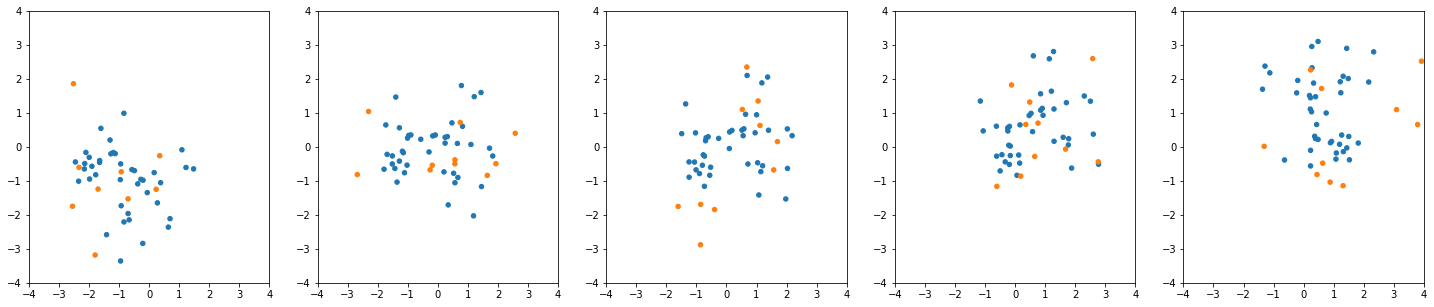

In [11]:
fig,ax = plt.subplots(1,5,figsize=(25,5))
for i in range(5):
    ax[i].set_xlim(-4,4)
    ax[i].set_ylim(-4,4)
    ax[i].scatter(Xs[i][:,0],Xs[i][:,1],s=1000*mu)
    ax[i].scatter(ns[i][:,0],ns[i][:,1],s=1000*nus[i])

In [12]:
Xns = [np.concatenate([Xs[i],ns[i]]) for i in range(5)]
muns = [np.concatenate([mu,nus[i]]) for i in range(5)]

In [13]:
pix_grid = [100,100]

In [14]:
imgs_n = [utils.atomic2img(ns[i],nus[i],n_pix=pix_grid,sigma=1,extent=np.array([[-4,4],[-4,4]])) for i in range(5)]
imgs_t = [utils.atomic2img(Xs[i],mu,n_pix=pix_grid,sigma=1,extent=np.array([[-4,4],[-4,4]])) for i in range(5)]
 
imgs_f = np.array(imgs_t) + np.array(imgs_n)

for i in range(5):
    imgs_n[i][imgs_n[i] < 1e-5] = 0
    imgs_t[i][imgs_t[i] < 1e-5] = 0

In [15]:
Ys = []
Ms = []
heights = []
noise_lens = []
mults = []
for i in range(5):
    tmp1 = utils.mm_space_from_img(imgs_t[i],normalize_meas=False)
    tmp2 = utils.mm_space_from_img(imgs_n[i],normalize_meas=False)
    noise_lens.append(len(tmp2[0]))
    Y = np.concatenate([tmp1[0],tmp2[0]])
    M = ot.dist(Y,Y,metric="euclidean")
    #np.concatenate([tmp1[1],tmp2[1]])
    height = np.concatenate([tmp1[2],tmp2[2]])
    mults.append(np.sum(height))
    height /= np.sum(height)
    Ys.append(Y)
    Ms.append(M)
    heights.append(height)
max_M = max([np.max(M) for M in Ms])
Ms = [M/max_M for M in Ms]

In [16]:
rho = 0.001
eps = 0.0002

In [17]:
r,forward_MGW = create_line_tree(5)
for i in range(5):
    node = forward_MGW[i]
    node.mu = torch.from_numpy(heights[i])
    node.M = torch.from_numpy(Ms[i])
    #node.rho = torch.Tensor([torch.inf])
    node.rho = torch.Tensor([rho])
    node.sep = None
    #node.rho = np.inf
    if node.is_root:
        node.cost = None

In [18]:
r,log = umgw.UMGW_sep(r,eps= eps,rho=None,plan_cvgce_thres=5e-7,sink_cvgce_thres=1e-6,n_its_check_cvgce=10,n_its = 300,log=True,max_time=120,random_state=0)


Terminated after 31 iterations with last update 2.556040605822111e-07.


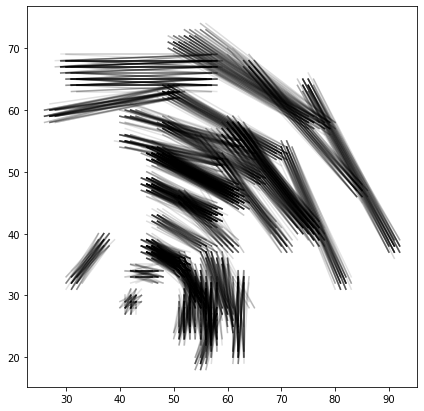

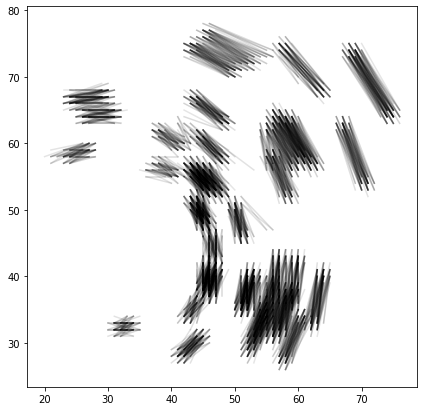

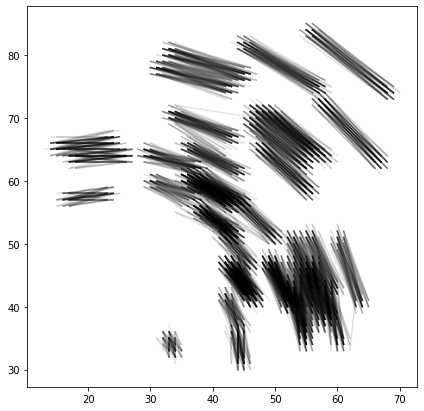

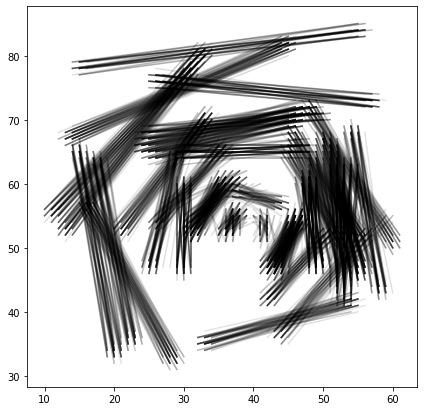

In [19]:
for i in range(4):
    utils.plot_samples_mat(Ys[i],Ys[i+1],np.array(forward_MGW[i+1].pi),thr=1e-1)
    plt.show()

In [20]:
MGW_prop = np.copy(heights[0])
MGW_prop[-noise_lens[0]:] = 0
#MGW_prop /= np.sum(MGW_prop)
#tmp /= np.sum(tmp)
MGW_props = [MGW_prop]
for i in range(4):#
    pi = np.array(forward_MGW[i+1].pi)
    MGW_prop = (np.sum(pi,axis=1)[:,None]**(-1) * np.array(pi)).T.dot(torch.from_numpy(MGW_prop))
    MGW_props.append(MGW_prop)
    #tmp /= np.sum(tmp)

In [21]:
col_imgs_t = [bw2col(imgs_t[i],entry=2) for i in range(5)]
col_imgs_n = [bw2col(imgs_n[i],entry=0) for i in range(5)]
col_imgs_f = np.array([(col_imgs_t[i] + col_imgs_n[i]) for i in range(5)])

col_imgs_f = [img / np.max(img[:,:,3]) for img in col_imgs_f]
#col_imgs_f[:,:,3] = col_imgs_f[:,:,3]/np.max(col_imgs_f[:,:,3])

In [22]:
for x in ax.ravel():
    x.axis("off")
cmap = "Purples"
data = []
col_prop_imgs = []
for i in range(5):
    marg_img = intatomic2img(pix_grid,Ys[i],forward_MGW[i].marginal)
    marg_img /= np.sum(marg_img)
    
    prop_img = intatomic2img(pix_grid,Ys[i],MGW_props[i])
    #prop_img /= np.sum(prop_img)    
    col_prop_img = np.copy(col_imgs_f[i])
    col_prop_img[:,:,3] = prop_img/np.max(prop_img)
    col_prop_imgs.append(col_prop_img)
    data.append([imgs_t[i]/np.sum(imgs_f[i]),imgs_n[i]/np.sum(imgs_f[i]),imgs_f[i]/np.sum(imgs_f[i]),marg_img,prop_img])

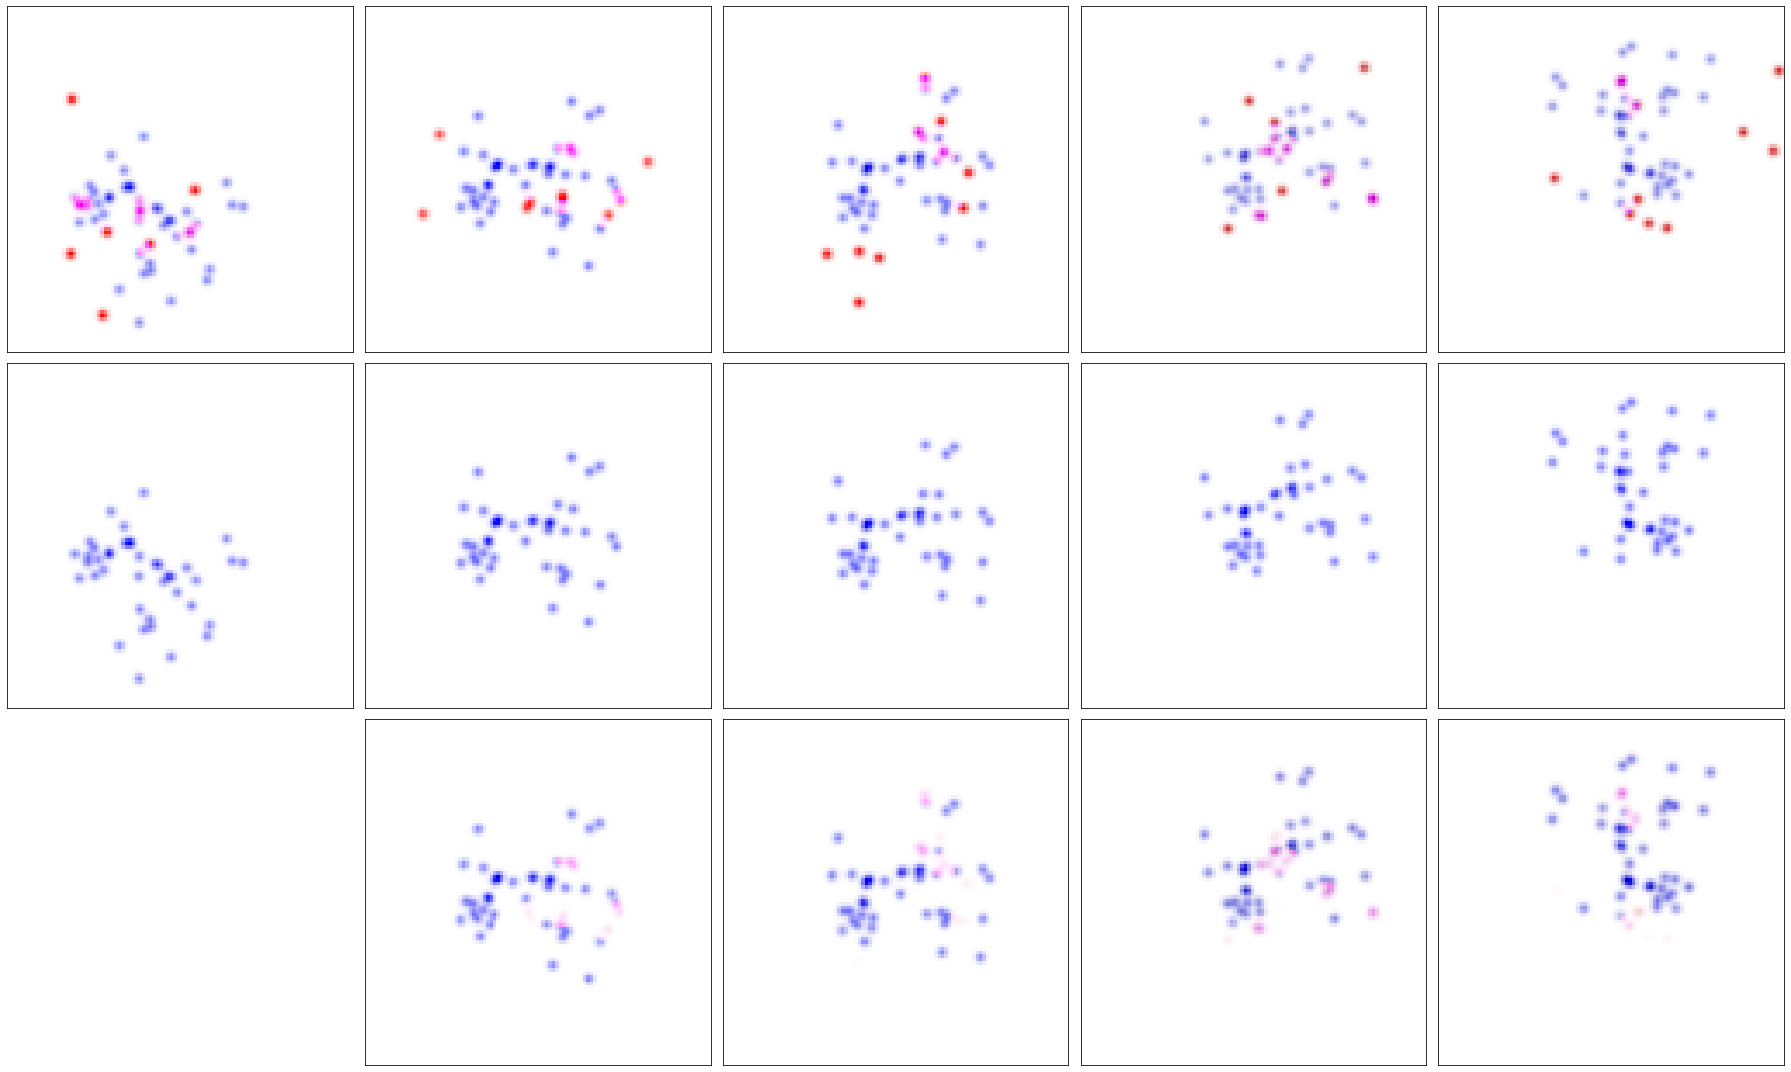

In [23]:
fig,ax = plt.subplots(3,5,figsize=(25,15))#,sharex=True,sharey=True)
#vmax = max([np.max(np.max(d)) for d in data])
for x in ax.ravel():
    x.set_xticks([])
    x.set_yticks([])
for i in range(5):
    img_t,img_n,img_f,marg_img,prop_img= data[i]
    ax[0,i].imshow(col_imgs_f[i])
    ax[1,i].imshow(col_imgs_t[i])
    ax[2,i].imshow(col_prop_imgs[i])
fig.delaxes(ax[2,0])
plt.tight_layout()